# Desafio Indicium - EDA

Este documento apresenta uma análise exploratória dos dados (EDA) de aluguéis temporários na cidade de Nova York, com o objetivo de desenvolver um modelo preditivo para preços.

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

## Data Overview

O dataset fornecido é composto de anúncios, com informações sobre as propriedades listadas, como localização, tipo de propriedade, preços, quantidade de avaliações, entre outras. A partir desses dados, buscaremos identificar padrões, tendências e fatores que influenciem os preços dos aluguéis, além de validar um modelo de previsão que possa ser utilizado para estratégias de precificação.

In [2]:
dados = pd.read_csv('teste_indicium_precificacao.csv')

In [3]:
dados.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


## Exploring the Data - Part 1 - Overview

### Sobre os tipos de dados


Esta seção apresenta uma visão geral dos tipos de dados presentes no dataset de aluguéis temporários em Nova York. O dataset contém 48.894 entradas e 16 colunas, com variáveis de diferentes tipos, incluindo strings, floats e inteiros. A seguir, são detalhados cada tipo de dado e suas características.

Os dados incluem variáveis de diferentes tipos:

* **Strings**: nome, host_name, bairro_group, bairro, room_type, ultima_review (data)

* **Floats**: latitude, longitude (dados geográficos), reviews_por_mes

* **Inteiros**: id, host_id, price, minimo_nottes, numero_de_reviews, calculado_host_listings_count, disponibilidade_365

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

### Sobre os dados faltantes

Esta seção aborda a análise de dados faltantes no dataset. Serão identificados a presença de valores ausentes em algumas colunas e discutidas as possíveis causas e tratamentos adequados para esses casos.

In [5]:
dados.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Foram identificados dados faltantes nas seguintes colunas:

* `nome`: 16 valores faltantes (0.0003% dos dados)

* `host_name`: 21 valores faltantes (0.0004% dos dados)

* `ultima_review`: 10.052 valores faltantes (20% dos dados)

* `reviews_por_mes`: 10.052 valores faltantes (20% dos dados)

Os valores faltantes em `ultima_review` e `reviews_por_mes` correspondem às mesmas entradas, o que sugere que esses podem ser anúncios novos ou de pessoas físicas, que ainda não receberam avaliações.

In [6]:
dados[(dados['ultima_review'].isna()) & (dados['reviews_por_mes'].isna())]['calculado_host_listings_count'].value_counts()[:10]

calculado_host_listings_count
1      6952
2       899
3       356
232     204
4       158
327     120
5       109
96      102
8        99
6        94
Name: count, dtype: int64

Como foi possível ver acima, a maior parte dos anúncios com dados faltantes está nas colunas `ultima_review` e `reviews_por_mes`, são possívelmente de pessoas físicas, pois a maior parte da contagem do `calculado_host_listings_count` é 1.

**A remoção de todas as entradas com valores faltantes** resultaria na perda de 20% dos dados, o que não é ideal. Portanto, **foi feita a remoção as colunas `ultima_review` e `reviews_por_mes`**, pois a natureza desses dados faltantes está relacionada a anúncios novos ou de pessoas físicas, e preenchê-los poderia introduzir viés ou ruído desnecessário ao modelo.

In [7]:
dados.drop(columns=['ultima_review', 'reviews_por_mes'], inplace=True)

Esta análise possibilitou a identificação e o tratamento dos dados faltantes de forma adequada, garantindo a qualidade do dataset para as próximas etapas de modelagem. A remoção das colunas `ultima_review` e `reviews_por_mes` foi uma decisão tomada para evitar a introdução de viés no modelo preditivo.

## Exploring the Data - Part 2

### Sobre as Colunas

Esta seção explora cada coluna do dataset separadamente, analisando suas características e criando gráficos das medidas estatísticas quando aplicável. Inicialmente, será apresentada uma visão geral das colunas e dos tipos de dados que nelas estão.


Para as colunas categóricas, temos:

* `bairro_group`: categórica nominal

* `bairro`: categórica nominal

* `room_type`: categórica nominal


Para as colunas numéricas, temos

* `latitude`: numérica contínua

* `longitude`: numérica contínua

* `price`: numérica discreta

* `minimo_noites`: numérica discreta

* `numero_de_reviews`: numérica discreta

* `calculado_host_listings_count`: numérica discreta

* `disponibilidade_365`: numérica discreta

Além dessas, também existem as colunas de identificação do anúncio (`id` e `nome`) e do proprietário (`host_id` e `host_name`).

Abaixo, estão as primeiras linhas das colunas categóricas e strings, e as primeiras linhas das colunas numéricas e identificadores, classificadas como tipo 'object' e 'number' no Pandas, respectivamente. . 

In [8]:
dados.select_dtypes(include='object').head()

,nome,host_name,bairro_group,bairro,room_type
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt
1,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room
2,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt
3,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt
4,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,Entire home/apt


In [9]:
dados.select_dtypes(include='number').head()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
0,2595,2845,40.75362,-73.98377,225,1,45,2,355
1,3647,4632,40.80902,-73.94190,150,3,0,1,365
2,3831,4869,40.68514,-73.95976,89,1,270,1,194
3,5022,7192,40.79851,-73.94399,80,10,9,1,0
4,5099,7322,40.74767,-73.97500,200,3,74,1,129


Observamos que as colunas categóricas, como `bairro_group` e `room_type`, podem ser úteis para análises segmentadas. As colunas numéricas, como `price` e `número_de_reviews`, são essenciais para a modelagem preditiva. A coluna `id` é única para cada entrada, o que a torna útil para identificação, mas não para análise estatística. A coluna `calculado_host_listings_count` contém a quantidade de listagem por host e pode nos ajudar a identificar, por exemplo, a existência de pessoas físicas e empresas especializadas em aluguel de imóveis.

In [10]:
dados_hosts = dados.drop_duplicates(subset='host_id', keep='first')
dados_hosts.shape

(37457, 14)

In [11]:
dados['calculado_host_listings_count'].value_counts()[:10]

calculado_host_listings_count
1      32303
2       6658
3       2853
4       1440
5        845
6        569
8        416
7        399
327      327
9        234
Name: count, dtype: int64

In [12]:
dados[dados['calculado_host_listings_count'] == 327][['host_id','host_name']].iloc[0]

host_id         219517861
host_name    Sonder (NYC)
Name: 38292, dtype: object

In [13]:
dados[dados['calculado_host_listings_count'] == 232][['host_id','host_name']].iloc[0]

host_id       107434423
host_name    Blueground
Name: 26136, dtype: object

Ao analisar as aparições únicas de cada host_id podemos perceber que a quantidade de hosts é menor do que a quantidade total de dados, o que pode ser um indicativo da existência de empresas especializadas, e a partir da contagem feita esta hipótese pode ser confirmada. Com uma pesquisa nos dados e na internet, é possivel verificar a existência empresas nos dados, como por exemplo as empresas "[Sonder](https://www.sonder.com/destinations/new_york_city/search?sleeps=1&neighborhood=all_neighborhoods&bedroom_count=0&bed_count=1&bathroom_count=1) (NYC)" e "[Blueground](https://www.theblueground.com)", além disso a maioria dos hosts anunciaram apenas uma vez, o que provavelmente são pessoas anunciando seus próprios imóveis.

#### Categorical Variables

Esta seção explora separadamente as variáveis categóricas presentes no dataset, analisando a distribuição das categorias em cada coluna. Observamos uma grande discrepância nas quantidades de anúncios entre diferentes categorias, o que pode ser explicado por diversos fatores relacionados ao negócio.

In [14]:
dados['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

`bairro_group`: A maioria dos anúncios está concentrada em Manhattan e Brooklyn, o que pode ser explicado pela alta [densidade populacional](https://pt.wikipedia.org/wiki/Nova_Iorque#:~:text=Manhattan%2C%20Condado%20de%20Nova%20Iorque%2C%20%C3%A9%20o%20centro%20econ%C3%B4mico%20da%20cidade%2C%20e%20tamb%C3%A9m%20onde%20a%20cidade%20de%20Nova%20Iorque%20possui%20suas%20origens.%20%C3%89%20o%20distrito%20mais%20densamente%20habitado%20de%20Nova%20Iorque%20(%C3%A9%20o%20condado%20mais%20densamente%20habitado%20do%20pa%C3%ADs)%2C%20e%20onde%20se%20localizam%20a%20maioria%20dos%20arranha%2Dc%C3%A9us%20da%20cidade.) e pela presença de [pontos turísticos](https://pt.wikipedia.org/wiki/Manhattan#Censo_2020:~:text=%5B25%5D-,Características,pontos%20turísticos%20americanos%20mais%20conhecidos%20e%20visitados%20dos%20Estados%20Unidos.,-Organização) importantes.

In [15]:
dados['bairro'].value_counts()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Fort Wadsworth           1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

`bairro`: A distribuição de anúncios por bairro mostra uma grande variedade, com alguns bairros tendo um número significativamente maior de anúncios. Essa coluna é muito influenciada pela anterior, tendo em vista que os cinco primeiros bairros são dos distritos do Brooklyn e Manhattan.

In [16]:
dados['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

`room_type`: A maioria dos anúncios é do tipo 'Entire home/apt', seguido por 'Private room' e 'Shared room'. A predominância de 'Entire home/apt' e 'Private room' em `room_type` pode ser atribuída à preferência dos hóspedes por mais privacidade e espaço.

#### Numerical Variables

Esta seção explora as variáveis numéricas presentes no dataset, analisando suas distribuições e identificando a presença ou não, de outliers. Essa análise detalhada pode ajudar a entender características específicas de cada coluna e o comportamento dos dados, além de nos fornecer insights sobre o negócio.

Observação: Para melhor visualização do comportamento das variáveis, nesta seção foram criados gráficos com e sem outliers, à esquerda e à direita, respectivamente.

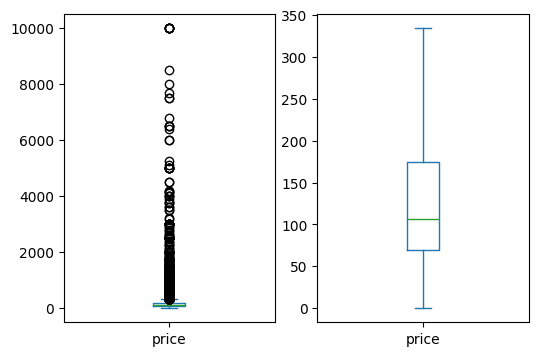

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

dados['price'].plot.box(ax=ax[0])
dados['price'].plot.box(showfliers=False, ax=ax[1])

plt.show()

`price`: Observamos uma grande quantidade de outliers. A ocorrência de outliers, nesse caso, pode ocorrer por falhas na coleta de dados, na própria criação dos anúncios, ou, no melhor dos casos, pode ocorrer naturalmente devido a características dos imóveis que interferem no preço como localização, espaço, capacidade, etc. Ao remover os outliers (gráfico à direitra), a distribuição dos preços fica mais homogênia, mas é notável uma assimetria do 'box' com relação aos 'whiskers'.

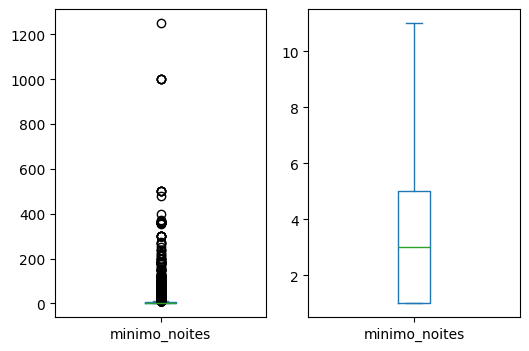

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

dados['minimo_noites'].plot.box(ax=ax[0])
dados['minimo_noites'].plot.box(showfliers=False, ax=ax[1])

plt.show()

`minimo_noites`: A distribuição mostra que a maioria dos anúncios tem um número baixo de noites mínimas, mas há alguns outliers com valores muito altos. Isso pode acontecer em situações em que o proprietário estabelece um contrato com número mínimo de meses para estadia, geralmente em aluguel de casas ou apartamentos.

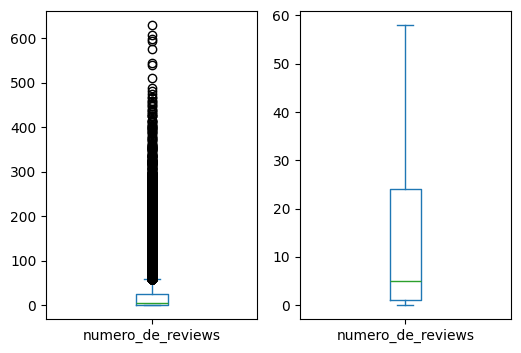

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

dados['numero_de_reviews'].plot.box(ax=ax[0])
dados['numero_de_reviews'].plot.box(showfliers=False, ax=ax[1])

plt.show()

`numero_de_reviews`: Esta variável também apresenta muitos outliers, indicando anúncios que receberam um número significativamente maior de avaliações, que podem indicar anúncios de lugares com muitas visitas.

<Axes: >

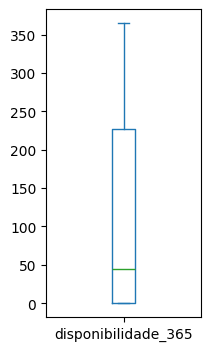

In [20]:
dados['disponibilidade_365'].plot.box(figsize=(2, 4))

`disponibilidade_365`: A maioria dos anúncios está disponível para reserva durante grande parte do ano, com alguns anúncios tendo disponibilidade limitada, possivelmente devido a alta demanda ou políticas específicas dos proprietários.

Esta análise das variáveis numéricas forneceu insights importantes sobre a distribuição dos preços, mínimo de noites, número de reviews e disponibilidade dos anúncios. A presença de outliers em várias variáveis indica a necessidade de um tratamento cuidadoso desses dados para evitar distorções na modelagem preditiva. Para este caso, é evidente que os dados outliers na verdade têm relação direta com o negócio. Assim, a remoção desses outliers será feita para fins estratégicos de modelagem, com a finalidade de melhorar a eficiência do modelo.

## Exploring the Data - Part 3

### About Price

Esta seção explora primeiramente as relações entre a variável alvo (`price`) e algumas variáveis do dataset. Através de visualizações, buscamos identificar padrões e tendências que possam influenciar os preços dos aluguéis temporários em Nova York.

Observação: Para melhor visualização do comportamento das variáveis, nesta seção foram criados gráficos com e sem outliers, à esquerda e à direita, respectivamente.

Text(0.5, 1.0, 'Price variation of bairro_group without outliers')

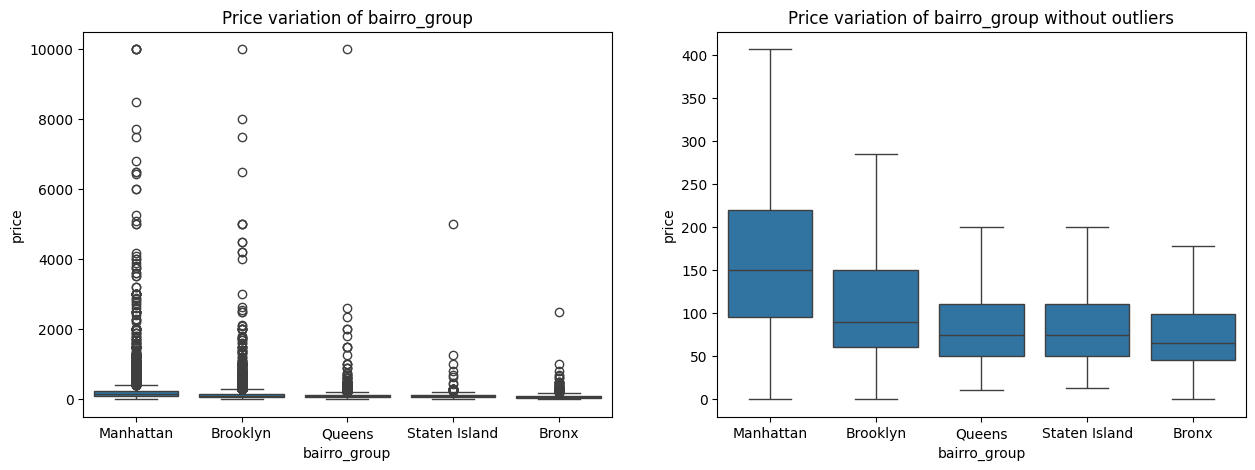

In [21]:
var = 'bairro_group'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dados, x=var, y='price', ax=axes[0])
sns.boxplot(data=dados, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

`bairro_group`: Observamos que os preços variam significativamente entre os distritos, com Manhattan apresentando os preços mais altos e Bronx os mais baixos.

Text(0.5, 1.0, 'Price variation of room_type without outliers')

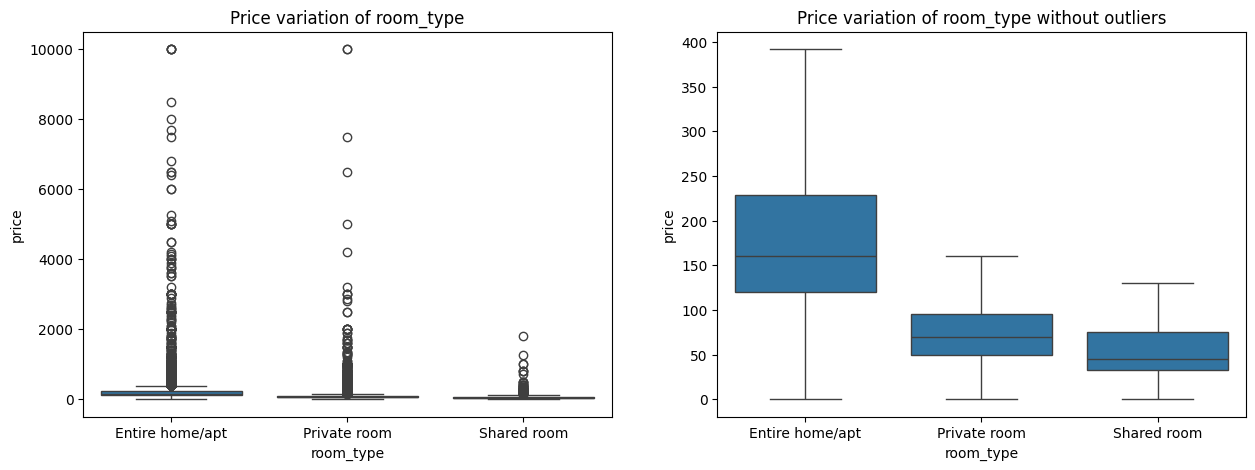

In [22]:
var = 'room_type'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dados, x=var, y='price', ax=axes[0])
sns.boxplot(data=dados, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

`room_type`: O tipo de quarto também influencia o preço, com 'Entire home/apt' sendo o mais caro, seguido por 'Private room' e 'Shared room'.

Text(0.5, 0.98, 'Price distribution over latitude and longitude')

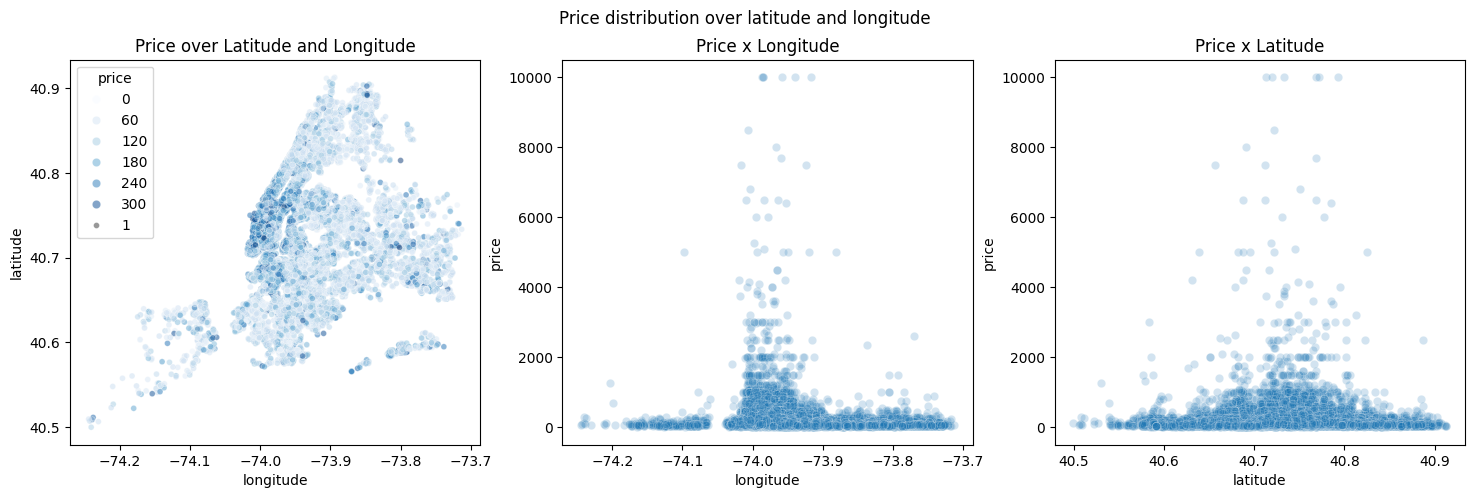

In [23]:
q1_price, q3_price = dados['price'].quantile([0.25, 0.75])
iqr_price = q3_price - q1_price
inf_price, sup_price = q1_price - 1.5 * iqr_price, q3_price + 1.5 * iqr_price

fig, ax = plt.subplots(1,3,figsize=(18, 5))

sns.scatterplot(data=dados[(dados['price'] >= inf_price) & (dados['price'] <= sup_price)], y='latitude', x='longitude', hue='price', ax=ax[0], size=1, alpha=0.5, palette='Blues')
sns.scatterplot(data=dados, y='price', x='longitude', alpha=0.2, ax=ax[1], legend=False)
sns.scatterplot(data=dados, y='price', x='latitude', alpha=0.2, ax=ax[2], legend=False)

ax[0].set_title('Price over Latitude and Longitude')
ax[1].set_title('Price x Longitude')
ax[2].set_title('Price x Latitude')

fig.suptitle('Price distribution over latitude and longitude')

`latitude` e `longitude`: A localização geográfica dos imóveis tem um impacto considerável no preço, com áreas centrais como Manhattan apresentando preços mais elevados.

Conclusões:

* Os preços variam significativamente entre os distritos, com Manhattan apresentando os preços mais altos, seguido por Brooklyn, Queens, Staten Island e Bronx. Isso pode ser explicado pela alta demanda e localização privilegiada de Manhattan. 
* Em relação ao tipo de quarto, 'Entire home/apt' é o mais caro, refletindo a preferência dos hóspedes por mais privacidade e espaço. 
* A localização geográfica também tem um impacto considerável, com áreas centrais apresentando preços mais elevados.

### About the other variables 

Agora, serão exploradas as relações entre as variáveis não-alvo do dataset, buscando identificar padrões e tendências que possam fornecer insights adicionais sobre os dados, buscando entender como diferentes variáveis se relacionam entre si.

Text(0.5, 0.98, 'room_type distribution')

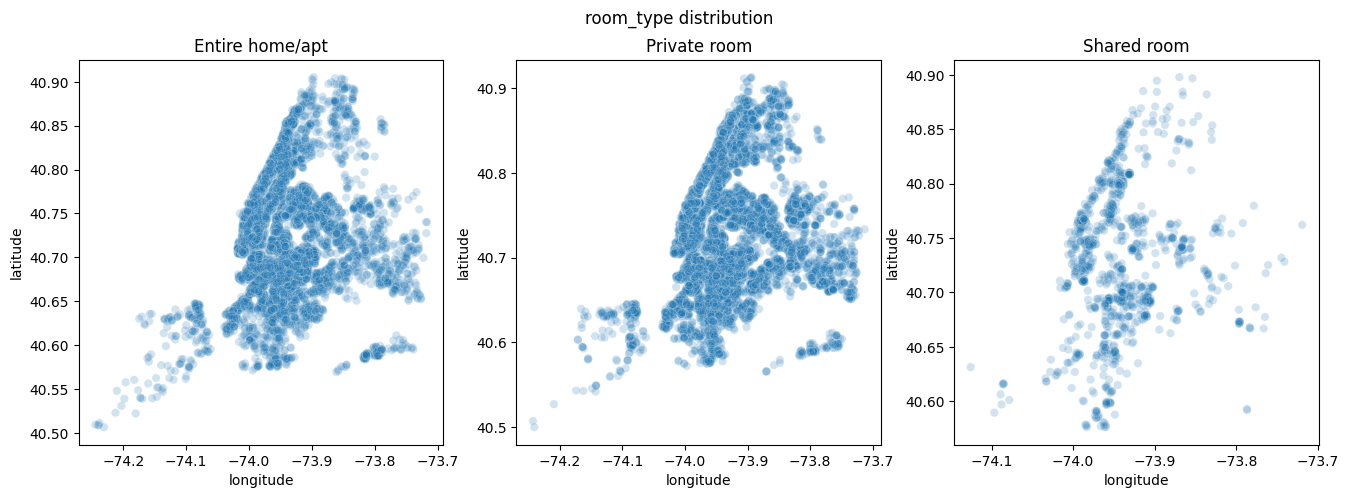

In [24]:
fig, ax = plt.subplots(1,3,figsize=(16, 5))

sns.scatterplot(data=dados[dados['room_type'] == 'Entire home/apt'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[0], legend=False)
sns.scatterplot(data=dados[dados['room_type'] == 'Private room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[1], legend=False)
sns.scatterplot(data=dados[dados['room_type'] == 'Shared room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[2], legend=False)

ax[0].set_title('Entire home/apt')
ax[1].set_title('Private room')
ax[2].set_title('Shared room')

fig.suptitle('room_type distribution')

`room_type` e `latitude`/`longitude`: A distribuição dos tipos de quarto é relativamente homogênea em toda a cidade, com 'Entire home/apt' e 'Private room' sendo os mais comuns, enquanto 'Shared room' é menos frequente.

Text(0.5, 1.0, 'room_type x numero_de_reviews *without outliers')

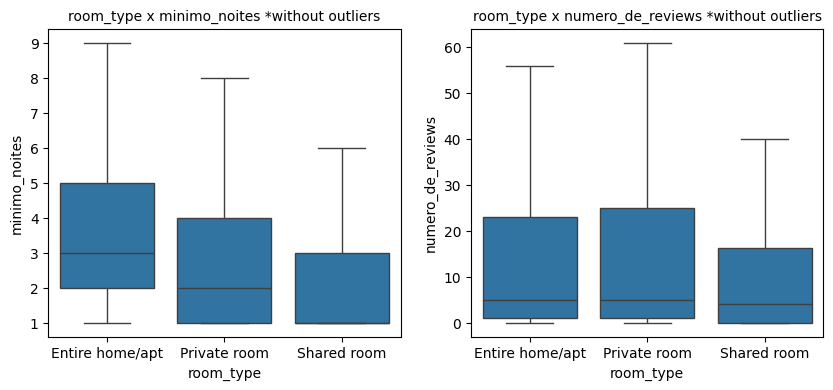

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=dados, x='room_type', y='minimo_noites', showfliers=False, ax=axes[0])
sns.boxplot(data=dados, x='room_type', y='numero_de_reviews', showfliers=False, ax=axes[1])

axes[0].set_title(f'room_type x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'room_type x numero_de_reviews *without outliers', fontsize=10)

`room_type` e `minimo_noites`: Apartamentos inteiros ('Entire home/apt') tendem a ter um número mínimo de noites maior em comparação com quartos privados ('Private room') e compartilhados ('Shared room').

`room_type` e `numero_de_reviews`: Quartos privados ('Private room') apresentam um número de avaliações ligeiramente maior do que os outros tipos de quarto.

Text(0.5, 1.0, 'bairro_group x numero_de_reviews *without outliers')

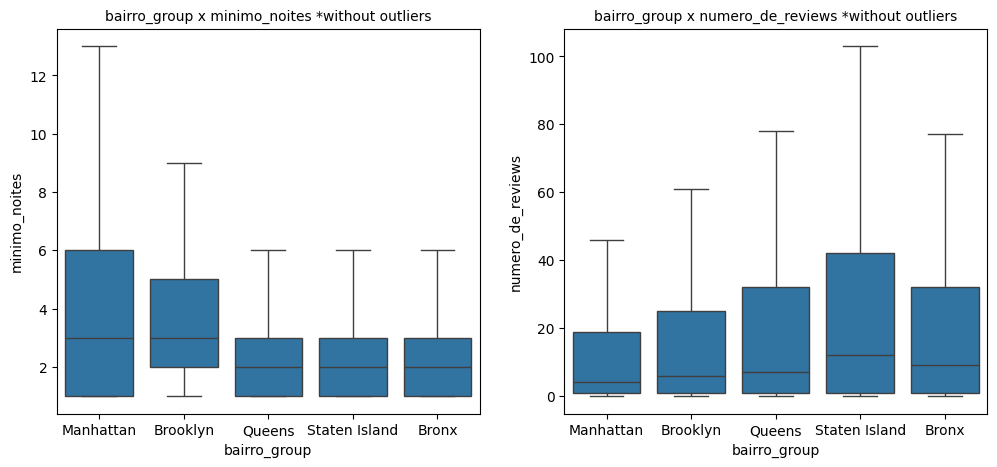

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=dados, x='bairro_group', y='minimo_noites', showfliers=False, ax=axes[0])
sns.boxplot(data=dados, x='bairro_group', y='numero_de_reviews', showfliers=False, ax=axes[1])

axes[0].set_title(f'bairro_group x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'bairro_group x numero_de_reviews *without outliers', fontsize=10)

`bairro_group` e `numero_reviews`/`minimo_noites`: Staten Island apresenta um número de avaliações estatisticamente maior do que os outros distritos, enquanto Manhattan tem um número mínimo de noites para reserva um pouco maior."

Conclusões:

* A distribuição dos tipos de quarto é relativamente homogênea em toda a cidade, com 'Entire home/apt' e 'Private room' sendo os mais comuns. 
* Quartos privados tendem a ter um número de avaliações ligeiramente maior, possivelmente devido à maior interação entre hóspedes e anfitriões. 
* Staten Island apresenta um número de avaliações estatisticamente maior, o que pode ser um indicativo de uma base de hóspedes mais ativa ou de políticas de incentivo a avaliações. 
* Manhattan tem um número mínimo de noites para reserva um pouco maior, refletindo possivelmente uma maior demanda, políticas de hospedagem mais restritivas ou um fluxo de pessoas mais alto devido ao turismo na região.

### Correlation Map

In [27]:
df_encoded = pd.concat((dados, pd.get_dummies(dados['room_type'], dtype=int), pd.get_dummies(dados['bairro_group'], dtype=int)), axis=1).drop(columns=['room_type', 'bairro_group'])
df_encoded = df_encoded.select_dtypes(include=['number']).drop(columns=['id','host_id'])
colunas = ['price'] + [coluna for coluna in df_encoded.columns if coluna != 'price']
df_encoded = df_encoded[colunas]
df_encoded.head()

,price,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,225,40.75362,-73.98377,1,45,2,355,1,0,0,0,0,1,0,0
1,150,40.80902,-73.94190,3,0,1,365,0,1,0,0,0,1,0,0
2,89,40.68514,-73.95976,1,270,1,194,1,0,0,0,1,0,0,0
3,80,40.79851,-73.94399,10,9,1,0,1,0,0,0,0,1,0,0
4,200,40.74767,-73.97500,3,74,1,129,1,0,0,0,0,1,0,0


<Axes: >

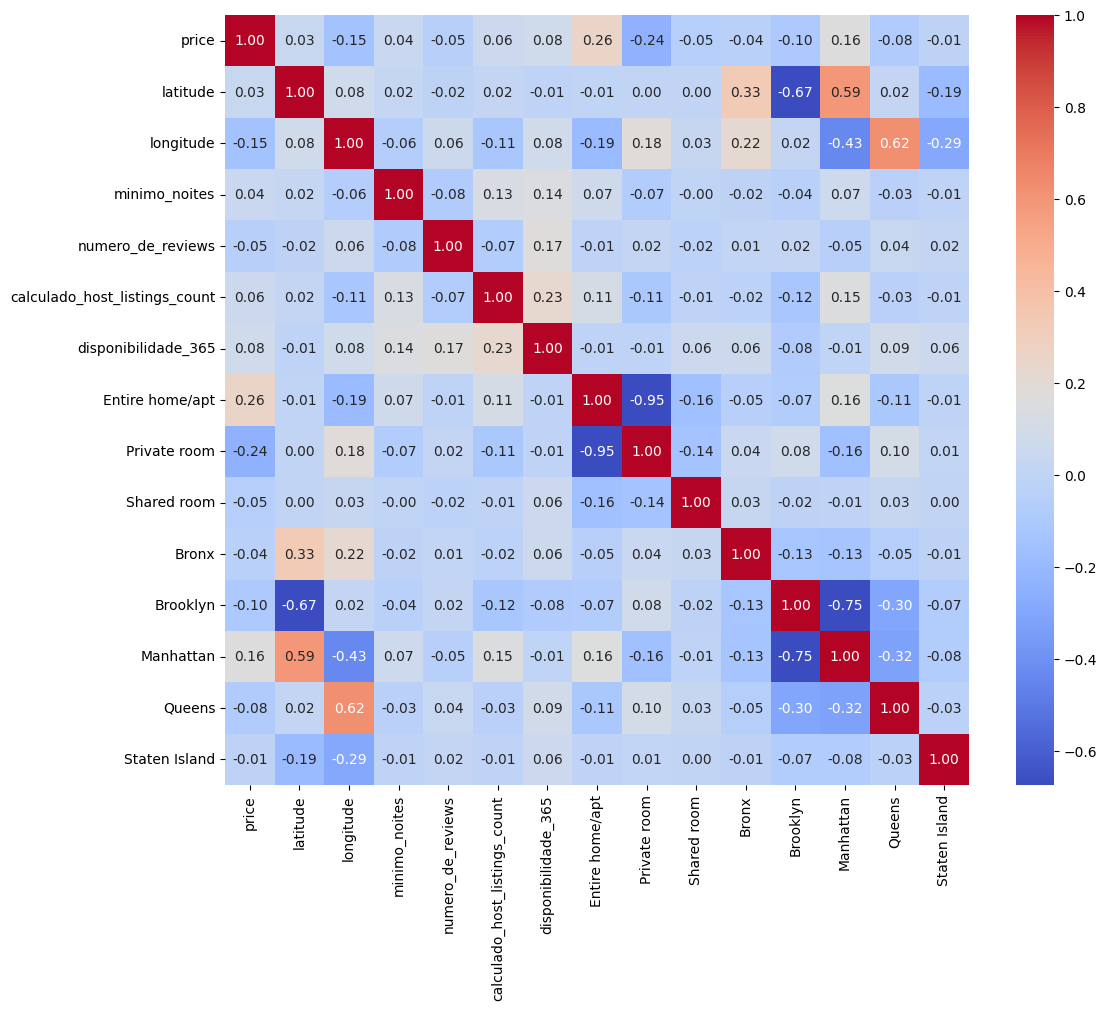

In [28]:
matrix_corr = df_encoded.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(matrix_corr, annot=True, cmap="coolwarm", fmt=".2f", robust=True)

Olhando para o mapa de correlação podemos notar que a variável `price` não apresenta um coeficiente alto de correlação com nenhuma variável, entretando podemos observar que existe uma correlação, ainda que fraca, entre `price` e as variáveis referentes ao tipo de propriedade (`Entire home/apt` e `Private room`), provenientes do `room_type`, e locais (`Manhattan` e `Brooklyn`), provenientes do `bairro_group`. Além disso, as variáveis referentes ao `bairro_group` apresentam correlação moderada com `latitude` e `longitude`.

A análise das relações entre a variável alvo (price) e outras variáveis nos forneceu insights importantes sobre os fatores que influenciam os preços dos aluguéis temporários em Nova York. Além disso, também foi possível compreender como as variáveis não-alvo se relacionam, e essas informações serão úteis para a etapa da modelagem preditiva.

## Respondendo as Questões:

#### 1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Esta é uma pergunta difícil pois para determinar o melhor distrito para investir em um apartamento para alugar na plataforma, devem ser considerados diversos fatores, como densidade populacional, conectividade, atratividade turística, segurança e mercado imobiliário. Vamos analisar cada distrito e identificar as melhores opções de investimento. Além disso, a escolha final ficará a critério do perfil do investidor.

Abaixo serão listados os prós e contras para cada distrito da cidade de Nova York, ao final será dada a opinião do autor a respeito do tema.

* Manhattan:
    * Prós: 
        * Lar dos [pontos turísticos](https://en.wikipedia.org/wiki/Manhattan#Tourism:~:text=O%20turismo%20%C3%A9,%5B%20228%20%5D) mais conhecidos de Nova Iorque;
        * Economia: Centro econômico da cidade, [maior renda per capta dos EUA](https://en.wikipedia.org/wiki/Manhattan#Economy:~:text=Manhattan%20%C3%A9%20o%20motor%20econ%C3%B4mico%20da%20cidade%20de%20Nova%20York);
        * Acessibilidade, o distrito conta com um moderno sistema de [transporte público](https://en.wikipedia.org/wiki/Manhattan#Infrastructure:~:text=Public%20transportation%5B,in%20New%20Jersey.);
        * Reconhecidamente o [setor imobiliário](https://en.wikipedia.org/wiki/Manhattan#Real_estate:~:text=O%20mercado%20imobili%C3%A1rio,em%20Midtown%20Manhattan.) é um dos pilares da economia de Manhattan, o que pode levar a valorização do imóvel que foi investido;
    * Contras:
        * As análises acima mostram que os valores dos imóveis são altos, o que levaria a um investimento inicial elevado;
        * Para um investidor mais conservador a concorrência pode ser um problema, pois como vimos, o mercado imobiliário já está bem estabelecido;

* Brooklyn:
    * Prós:
        * O distrito têm áreas muito valorizadas, como o bairro de [Williamsburg](https://en.wikipedia.org/wiki/Williamsburg,_Brooklyn);
        * Além da vasta [diversidade cultural](https://en.wikipedia.org/wiki/Culture_of_Brooklyn), o ambiente vibrante é muito atrativo para turistas;
        
    * Contras:
        * Densidade populacional alta, é o [distrito mais populoso da cidade](https://en.wikipedia.org/wiki/Brooklyn#:~:text=As%20of%20the%202020%20United%20States%20census%2C%5B1%5D%20the%20population%20stood%20at%202%2C736%2C074%2C%20making%20it%20the%20most%20populous%20of%20the%20five%20boroughs%20of%20New%20York%20City%2C%20and%20the%20most%20populous%20county%20in%20the%20state.%5B5%5D%5B6%5D%5B7%5D);
        * Mobilidade Urbana, acessibilidade e [transporte público](https://en.wikipedia.org/wiki/Brooklyn#Transportation:~:text=Aproximadamente%2092%2C8%25%20dos%20moradores%20do%20Brooklyn%20que%20viajam%20para%20Manhattan%20usam%20o%20metr%C3%B4%2C%20apesar%20do%20fato%20de%20alguns%20bairros%20como%20Flatlands%20e%20Marine%20Park%20serem%20mal%20atendidos%20pelo%20servi%C3%A7o%20de%20metr%C3%B4.%20As%20principais%20esta%C3%A7%C3%B5es%2C%20das%20170%20atualmente%20no%20Brooklyn%20%2C%20incluem%3A) podem ser um problema, visto que alguns bairros não são atendidos pelo serviço de metrô;

* Queens:
    * Prós:
        * [Proximidade com o aeroporto da cidade](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/5_Boroughs_Labels_New_York_City_Map.svg/800px-5_Boroughs_Labels_New_York_City_Map.svg.png), proporcionando um constante fluxo de pessoas;
        * Em área, é o maior dos cinco distritos;
        * Recebe muitos estrangeiros, que são [quase metade da população total](https://en.wikipedia.org/wiki/Queens#Climate:~:text=As%20approximately%2047%25%20of%20its%20residents%20are%20foreign%2Dborn%2C%5B10%5D%20Queens%20is%20highly%20diverse.);
        * [Economia diversificada](https://en.wikipedia.org/wiki/Queens#Economy:~:text=Queens%20has%20the%20second%2Dlargest,overwhelmingly%20dominant.%5B13%5D), a 2ª maior depois de Manhattan.
        * Conta com um elaborado sistema de [transporte público](https://en.wikipedia.org/wiki/Queens#Public_transportation:~:text=%5B166%5D-,Public%20transportation,-%5Bedit%5D);
    * Contras:
        * Menos conhecido internacionalmente em comparação com Manhattan;
        * Algumas áreas ainda estão em desenvolvimento.

* Staten Island:
    * Prós:
        * Preços baixos: como foi mostrado, é um dos distritos com preços mais baixos.
        * Qualidade de vida: Atrai famílias com [boas escolas](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Public%20schools%5B,the%20United%20States.) e [bairros suburbanos](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=it%20is%20also%20the%20least%20densely%20populated%20and%20most%20suburban%20borough%20in%20the%20city.) tranquilos.
        * Espaço ao ar livre: conhecido como o "[bairro dos parques](https://en.wikipedia.org/wiki/Staten_Island#:~:text=It%20has%20also%20been%20referred%20to%20as%20the%20%22borough%20of%20parks%22%20due%20to%20its%2012%2C300%20acres%20of%20protected%20parkland%20and%20over%20170%20parks.%5B10%5D%5B11%5D%5B12%5D%5B13%5D)", pelos mais de 170 parques e quase 5 mil hectares de áreas de mata protegida;
    * Contras:
        * A análise dos dados mostrou uma demanda menor de aluguéis;
        * Isolamento: Pelo fato de ser uma ilha o acesso é limitado ao resto de Nova York, além disso o transporte público é menos eficiente pois [não é contectada ao sistema de metrô](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Staten%20Island%20is%20the%20only%20borough%20not%20connected%20to%20the%20New%20York%20City%20Subway%20system.).
        * Segundo os próprios moradores, o distrito é [negligenciado pelo governo da cidade e pela mídia](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Staten%20Island%20has%20sometimes%20been%20called%20%22the%20forgotten%20borough%22%20by%20inhabitants%20who%20feel%20neglected%20by%20the%20city%20government%20and%20the%20media.);

* Bronx:
    * Prós:
        * Preços baixos para compra de imóveis;
        * Há muito espaço para crescimento econômico, o governo local têm trabalhado em iniciativas nesse aspecto;
    * Contras:
        * É um distrito [predominantemente residensial](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=Bronx%20%C3%A9%20um%20distrito%20predominantemente%20residencial);
        * [É o distrito mais pobre e violento da cidade de Nova York](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=%C3%89%20atualmente%20o%20distrito%20mais%20pobre%20e%20violento%20da%20cidade%2C%20bem%20como%20um%20dos%20condados%20mais%20pobres%20e%20violentos%20do%20pa%C3%ADs.%5B185%5D);
        * Na análise, foi visto que os preços de aluguel são baixos, ou seja, a rentabilidade será menor;


No fim, a escolha dependerá do perfil do investidor, e do que se espera alcançar em termos de rentabilidade e público-alvo. Abaixo segue uma lista com as indicações em alguns cenários: 

* Se deseja alta rentabilidade: Manhattan (se o orçamento permitir) ou Brooklyn (em áreas de rápido crescimento, como Williamsburg).
* Se deseja investimento acessível: Bronx (em áreas revitalizadas) ou Queens (com potencial de crescimento futuro).
* Se deseja aluguel de longo prazo para famílias: Staten Island (com foco em inquilinos suburbanos).

#### 2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Vamos analisar os dados para identificar se as variáveis `minimo_noites` e `disponibilidade_365` interferem no preço. Primeiramente, vamos observar o comportamento das duas variáveis em relação ao preço, para tal vamos utilizar como ferramenta o gráfico de dispersão.

Text(0.5, 1.0, 'Relação entre Preço e Disponibilidade ao longo do Ano')

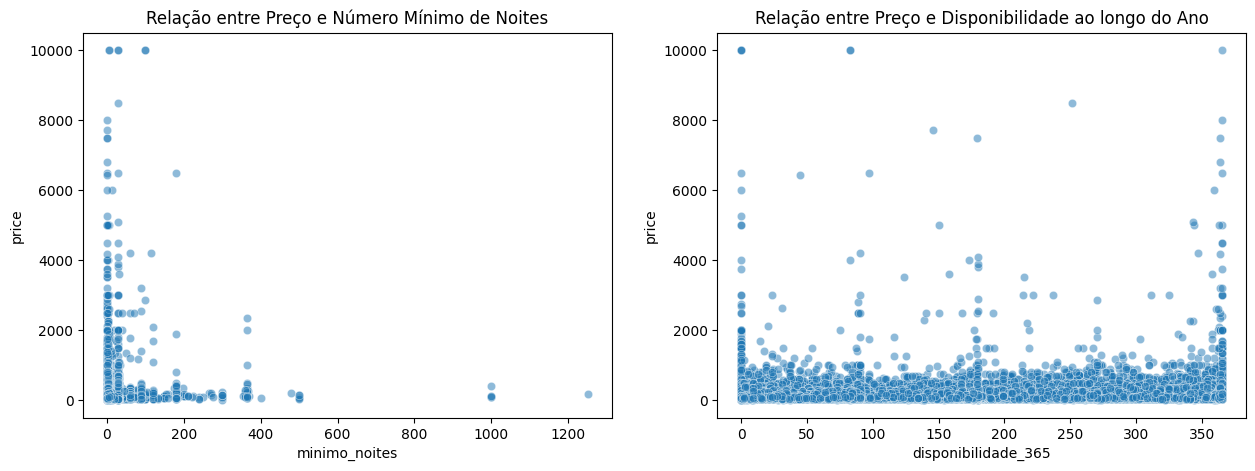

In [29]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(data=dados, x='minimo_noites', y='price', alpha=0.5, ax=axes[0])
sns.scatterplot(data=dados, x='disponibilidade_365', y='price', alpha=0.5, ax=axes[1])

axes[0].set_title("Relação entre Preço e Número Mínimo de Noites")
axes[1].set_title("Relação entre Preço e Disponibilidade ao longo do Ano")

Ao observar os gráficos acima não é possível identificar com clareza alguma relação das variáveis `minimo_noites` e `disponibilidade_365` com a variável `price`. Como segundo passo, vamos analisar a matriz de correlação, utilizando o método de pearson. A correlação nos ajudará entender se há alguma dependência ou relação estatística entre as variáveis. Um detalhe para a correlação de pearson é que esta medida é muito sensível a outliers, então precisamos removê-los para fazer o teste. Para a remoção, vamos utilizar o [Método de Tukey](https://medium.com/@lucapqg/como-detectar-e-tratar-outliers-com-python-ca2cf088c160#:~:text=M%C3%A9todo%20de%20Tukey,%F0%9D%90%BF%F0%9D%91%A0%F0%9D%91%A2%F0%9D%91%9D%20%3D%20%F0%9D%91%843%20%2B%20(1.5%20%E2%88%97%20%F0%9D%90%BC%F0%9D%91%84%F0%9D%91%85)), consiste em definir os limites inferior e superior a partir do interquartil (IQR) e dos primeiros (Q1) e terceiros (Q3) quartis.

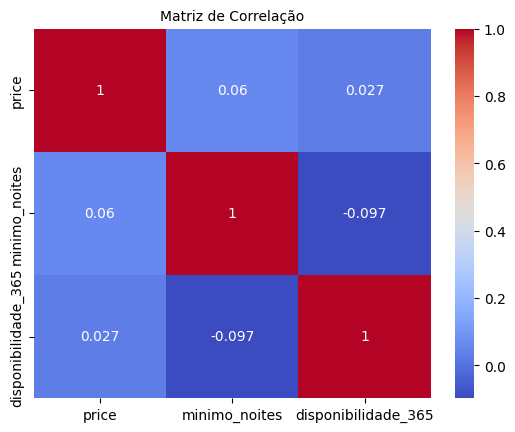

In [30]:
df = dados[['price', 'minimo_noites','disponibilidade_365']].copy()

q1_price, q3_price = df['price'].quantile([0.25, 0.75])
iqr_price = q3_price - q1_price
inf_price, sup_price = q1_price - 1.5 * iqr_price, q3_price + 1.5 * iqr_price

q1_min, q3_min = df['minimo_noites'].quantile([0.25, 0.75])
iqr_min = q3_min - q1_min
inf_min, sup_min = q1_min - 1.5 * iqr_min, q3_min + 1.5 * iqr_min

df = df[
    (df['price'] >= inf_price) & (df['price'] <= sup_price) &
    (df['minimo_noites'] >= inf_min) & (df['minimo_noites'] <= sup_min)
]

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação", fontsize=10)
plt.show()

Segundo a matriz de correlação, as variáveis não demonstraram importância estatisticamente significativa no preço. Para finalizar vamos fazer um teste de regressão linear utilizando a biblioteca statsmodels, o teste poderá nos dizer o quanto é possível determinar o preço a partir de `minimo_noites` e `disponibilidade_365`.

In [31]:
X = df[['minimo_noites', 'disponibilidade_365']]
X = sm.add_constant(X)
y = df['price']

# Regressão linear
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     93.51
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           3.06e-41
Time:                        13:08:39   Log-Likelihood:            -2.2348e+05
No. Observations:               39737   AIC:                         4.470e+05
Df Residuals:                   39734   BIC:                         4.470e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 111.1165    

A partir dos resultados podemos dizer que as variáveis `minimo_noites` e `disponibilidade_365` não interferem muito no preço, tendo em vista que o valor 'R-squared' é muito pequeno (0.005), o que significa que apenas 0.5% da variação em `price` é explicada pelos preditores, e o mesmo vale para o 'Adj. R-squared'.

#### 3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Primeiramente, é preciso encontrar quais são os lugares com mais alto valor. Para determinar os lugares com maiores preços, será criada uma tabela com o valor do quantil 90%, utilizando as colunas `bairro_group` e `room_type`.

In [32]:
df = dados.copy()

In [33]:
quantil_90_price = df.pivot_table(values='price', index='bairro_group', columns='room_type', aggfunc=lambda x: x.quantile(0.80))
quantil_90_price.sort_values(by='Entire home/apt', ascending=False, inplace=True)
quantil_90_price

room_type,Entire home/apt,Private room,Shared room
bairro_group,,,
Manhattan,295.0,130.0,99.0
Brooklyn,200.0,90.0,50.0
Queens,185.0,80.0,60.0
Staten Island,180.0,80.0,83.0
Bronx,150.0,75.0,60.0


A partir da tabela acima é possível notar que, no quantil 90%, os aluguéis mais caros são de casas e apartamentos em Manhattan. A partir dessa tabela, serão filtrados os anúncios com preços maiores que os do quantil 90%, para cada combinação de `room_type` e `bairro_group`.

In [34]:
def filter_prices(row):
    if row['price'] > (quantil_90_price.loc[row['bairro_group'], row['room_type']]):
        return True
    else:
        return False

Ao aplicar o filtro, com a função acima, foram obtidos os dados de anúncios com preços mais caros em cada cenário de `room_type` e `bairro_group`. Com esses dados, será possível buscar título dos anúncios, presentes na coluna `nome`, se há algum padrão no texto para lugares de mais alto valor.

In [35]:
dados_filtered = df[df.apply(filter_prices, axis=1)].copy()
dados_filtered['nome'] = dados_filtered['nome'].astype(str)
dados_filtered.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
15,7097,Perfect for Your Parents + Garden,17571,Jane,Brooklyn,Fort Greene,40.69169,-73.97185,Entire home/apt,215,2,198,1,321


In [36]:
dados_filtered.shape

(9376, 14)

Para procurar os padrões será usada a seguinte estratégia:

* Todas as palavras serão transformadas em minúsculas;
* Em cada entrada da coluna `nome`, serão retiradas: pontuações, stop words e números;
* Será feita uma lista de listas, contento cada palavra filtrada, de cada entrada da coluna `nome`;
* As palavras serão contadas, e ao final será obtido um dicionário com as 50 palavras mais frequêntes;

In [37]:
ad_names = dados_filtered['nome'].apply(lambda x: re.findall(r'\b\w{4,}\b', str(x).lower()))
ad_names = np.concatenate(ad_names.values).tolist()
words_list = dict(Counter(ad_names).most_common(50))
words_list

{'bedroom': 1416,
 'room': 1306,
 'private': 1240,
 'apartment': 973,
 'williamsburg': 787,
 'with': 745,
 'loft': 720,
 'brooklyn': 671,
 'manhattan': 653,
 'luxury': 639,
 'spacious': 622,
 'park': 607,
 'cozy': 504,
 'beautiful': 465,
 'village': 439,
 'home': 424,
 'bath': 410,
 'east': 409,
 'modern': 384,
 'duplex': 372,
 'heart': 372,
 'midtown': 371,
 'near': 365,
 'sunny': 357,
 'large': 352,
 'central': 349,
 'studio': 327,
 'west': 322,
 'location': 290,
 'square': 288,
 'from': 281,
 'brownstone': 278,
 'times': 264,
 'suite': 259,
 'bright': 257,
 'house': 249,
 'garden': 244,
 'huge': 243,
 'townhouse': 239,
 'prime': 204,
 'amazing': 203,
 'city': 202,
 'views': 201,
 'chelsea': 197,
 'view': 196,
 'penthouse': 186,
 'soho': 184,
 'side': 183,
 'charming': 179,
 'bathroom': 175}

Ao analisar as palavras mais frequentes, nota-se a predominância de palavras padronizadas de anúncios como: studio, bedroom, apartment, village, etc. Além dessas, ainda há palavras que descrevem características do padrão de vida do lugar: luxury, modern, private, spacious, beautiful, amazing, prime, etc. Para uma análise mais aprofundada, foram feitos um gráfico e uma tabela comparativa, para visualizar a diferença nos preços médios entre anúncios que utilizam palavras associadas a padrões de luxo e os que não utilizam.

In [38]:
results = []
for word in words_list.keys():
    mean_has = dados_filtered[dados_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean()
    mean_no_has = dados_filtered[~dados_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean()
    results.append({'word': word, 'has': mean_has, 'no_has': mean_no_has})

table = pd.DataFrame(results)
table.set_index('word', inplace=True)

table['ratio'] = table['has']/table['no_has']
table.sort_values(by='ratio', ascending=False, inplace=True)

A tabela foi criada a partir da análise dos preços médios dos anúncios que possuem ou não as palavras 50 palavras filtradas. Para cada palavra, foi calculada a média dos preços dos anúncios que a contêm e dos que não a contêm. Em seguida, os resultados foram organizados em um DataFrame, incluindo uma coluna adicional com a razão entre os preços médios, permitindo a comparação direta. Essa coluna foi utilizada para ordenar as palavras, e aquelas com razão positiva foram selecionadas para criar o gráfico comparativo abaixo.

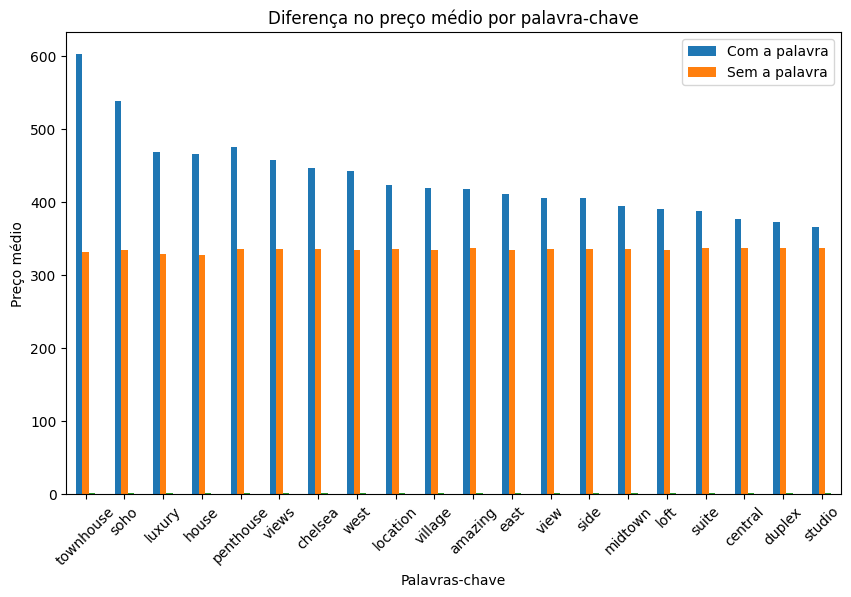

In [39]:
table.iloc[:20].plot(kind='bar', figsize=(10, 6))
plt.title('Diferença no preço médio por palavra-chave')
plt.xlabel('Palavras-chave')
plt.ylabel('Preço médio')
plt.xticks(rotation=45)
plt.legend(['Com a palavra', 'Sem a palavra'])
plt.show()

Os resultados indicam que anúncios que utilizam palavras associadas a padrões de luxo, como 'luxury', 'amazing' e 'townhouse' ou a regiões luxuosas como 'Soho', 'Chelsea' e 'Midtown', apresentam, em sua maioria, preços médios significativamente mais altos do que aqueles que não as utilizam. Essa tendência sugere que essas palavras podem ser utilizadas estrategicamente para atrair um público disposto a pagar mais por características percebidas como premium ou exclusivas. O gráfico gerado a partir da razão entre os preços reforça tal associação. Essa análise evidencia a influência do uso de palavras específicas na percepção e valorização de imóveis, podendo ser aplicada na elaboração de estratégias de marketing mais eficazes."

Esta Análise Exploratória de Dados nos permitiu entender as características e particularidades dos dados, o próximo passo é a modelagem preditiva, contida neste notebook: [Predictive_Modeling.ipynb](Predictive_Modeling.ipynb).